In [1]:
import torch
import math
import os
import matplotlib.pyplot as plt
from torch import optim
import torch._dynamo
from torchvision import models
from torch.profiler import profile, record_function, ProfilerActivity

pi = math.pi
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
def sin_taylor(x,n,device):
    sinx=0.
    factorial = lambda d: torch.lgamma(torch.tensor(d+1,device=device)).exp()
    for i in range(n):
        sinx += ((-1.)**i)*(x**(1+2*i))/factorial(2*i+1)
    return sinx

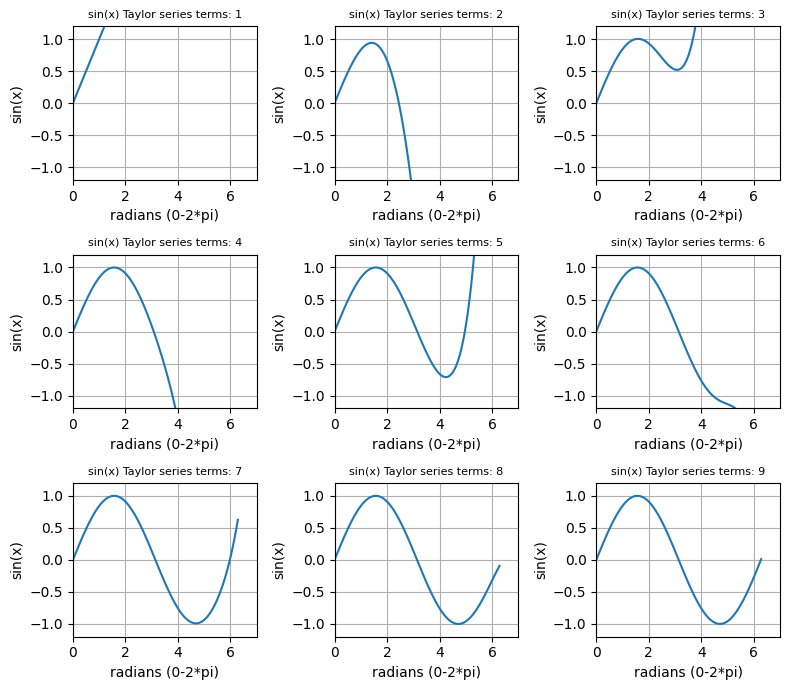

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3,figsize=(8,7))
rads = torch.linspace(0,2*pi,100)
ax=[b for a in ax for b in a]

counter=0
for i in range(1,10):
    sinx = lambda x: sin_taylor(x,i,device)
    ax[counter].plot(rads,sinx(rads.to(device)).cpu(),label=i)
    ax[counter].set_title(f'sin(x) Taylor series terms: {i}')
    ax[counter].set_xlabel('radians (0-2*pi)')
    ax[counter].set_ylabel('sin(x)')
    ax[counter].set_ylim([-1.2, 1.2])
    ax[counter].set_xlim([0,7])
    ax[counter].title.set_fontsize(8)
    ax[counter].grid()
    counter+=1
fig.tight_layout()

In [4]:
torch.manual_seed(0)
x = torch.rand(10000000, requires_grad=True).to(device)

n=10
model = lambda x: sin_taylor(x,n,device)

In [5]:
%time out = model(x).sum().backward()

CPU times: user 27.4 ms, sys: 9.07 ms, total: 36.5 ms
Wall time: 33.8 ms


In [6]:
torch._dynamo.reset()
compiled_model = torch.compile(model,options={'trace.enabled':True, 'trace.graph_diagram':True})
out = compiled_model(x).sum().backward()

[2023-03-30 18:28:23,779] torch._inductor.debug: [WARNING] model__0_forward_1 debug trace: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__0_forward_1.0


Writing FX graph to file: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__0_forward_1.0/graph_diagram.svg


[2023-03-30 18:28:24,016] torch._inductor.debug: [WARNING] model__0_backward_2 debug trace: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__0_backward_2.1


Writing FX graph to file: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__0_backward_2.1/graph_diagram.svg


In [7]:
%time out = compiled_model(x).sum().backward()

CPU times: user 35.6 ms, sys: 6.84 ms, total: 42.5 ms
Wall time: 16.6 ms


In [8]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CUDA,ProfilerActivity.CPU]) as prof:
    out = model(x).sum().backward()

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cuda_time_total", row_limit=5))

prof.export_chrome_trace("no_compile_trace.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       cudaLaunchKernel         1.35%     450.000us         1.35%     450.000us       4.091us      12.766ms        49.45%      12.766ms     116.055us           110  
                                            aten::copy_         0.23%      78.000us        72.46%      24.196ms       2.016ms      11.268ms        43.65%      11.404ms     950.333us            12  
         

STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [9]:
torch._dynamo.reset()
compiled_model = torch.compile(model,options={'trace.enabled':True, 'trace.graph_diagram':True})
out = compiled_model(x)

[2023-03-30 18:28:24,754] torch._inductor.debug: [WARNING] model__1_forward_4 debug trace: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__1_forward_4.2


Writing FX graph to file: /pytorch-examples/pytorch2-workshop-examples/torch_compile_debug/run_2023_03_30_18_28_23_632206-pid_5849/aot_torchinductor/model__1_forward_4.2/graph_diagram.svg


In [10]:
from torch.profiler import profile, record_function, ProfilerActivity
with profile(activities=[ProfilerActivity.CUDA],
            ) as prof:
    out = compiled_model(x)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cuda_time_total", row_limit=-1))

prof.export_chrome_trace("compiled_trace.json")

-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           triton__0d1d2d         0.00%       0.000us         0.00%       0.000us       0.000us     139.000us       100.00%     139.000us     139.000us             1  
    cudaDeviceSynchronize       100.00%       7.000us       100.00%       7.000us       7.000us       0.000us         0.00%       0.000us       0.000us             1  
-------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------

STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-03-30 18:28:24 5849:5849 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
